# Yelp Review Sentiment Classification With NLP

This notebook aims to create a sentiment classifier using Natural Language Processing using a Yelp Review Dataset.




In [1]:
import pandas as pd   # Great for tables (google spreadsheets, microsoft excel, csv).
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import spacy
import wordcloud
import os # Good for navigating your computer's files
import sys
pd.options.mode.chained_assignment = None #suppress warnings

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
nltk.download('wordnet')
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!python -m spacy download en_core_web_md
import en_core_web_md
text_to_nlp = spacy.load('en_core_web_md')



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 9.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Data

In [2]:
#load data - Yelp Dataset
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/yelp_final.csv"


yelp_final.csv      100%[===================>] 743.14K   843KB/s    in 0.9s    


In [3]:

yelp_full = pd.read_csv('yelp_final.csv')
yelp_full.head()

,business_id,stars,text,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,_1QQZuf4zZOyFCvXc0o6Vg,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,1,2,0
3,6ozycU1RpktNG2-1BroVtw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
4,zp713qNhx8d9KCJJnrw1xA,5,Drop what you're doing and drive here. After I...,wFweIWhv2fREZV_dYkz_1g,7,7,4


User name and business ID are excluded and hashed for data privacy. Now lets extract the text and stars columns as they are the only ones  needed for our model.




In [4]:
needed_columns = ['text','stars']
yelp = yelp_full[needed_columns]
yelp.head()

,text,stars
0,My wife took me here on my birthday for breakf...,5
1,I have no idea why some people give bad review...,5
2,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5
3,General Manager Scott Petello is a good egg!!!...,5
4,Drop what you're doing and drive here. After I...,5


View reviews for different star ratings.

In [5]:

num_stars =  3 #change this

for t in yelp[yelp['stars'] == num_stars]['text'].head(20).values:
    print (t)

We went here on a Saturday afternoon and this place was incredibly empty.  They had brunch specials going on, including $2 bloody mary's and mimosas, but we were more in the mood for lunch.  Except for the bloody mary, I had to try one.  It came out in a high-ball-sized glass.  Boo!  But it was really tasty. Yay!  The hubby remembered a sign outside the restaurant a few weeks back that said they had Arrogant Bastard, and he got a 22 oz bottle for $4.75.  Hey, that's not fair!!

Next up: the wings.  We were a bit hesitant to order them when the waitress informed us that they are "seasoned" but not sauced, so they can't be ordered hot.  We did ask for them crispy though, and the waitress even asked the cooks to throw them back in for a few minutes when they came out not visibly crispy.  These non-traditional wings were actually pretty damn good.  The seasoning was a little spicy and salty with just a hint of sweet.  If I were in the mood for the tang and kick of Frank's Hot Sauce, these 

## Word Clouds
Lets use word clouds to view the most prominent words in any given star rating.


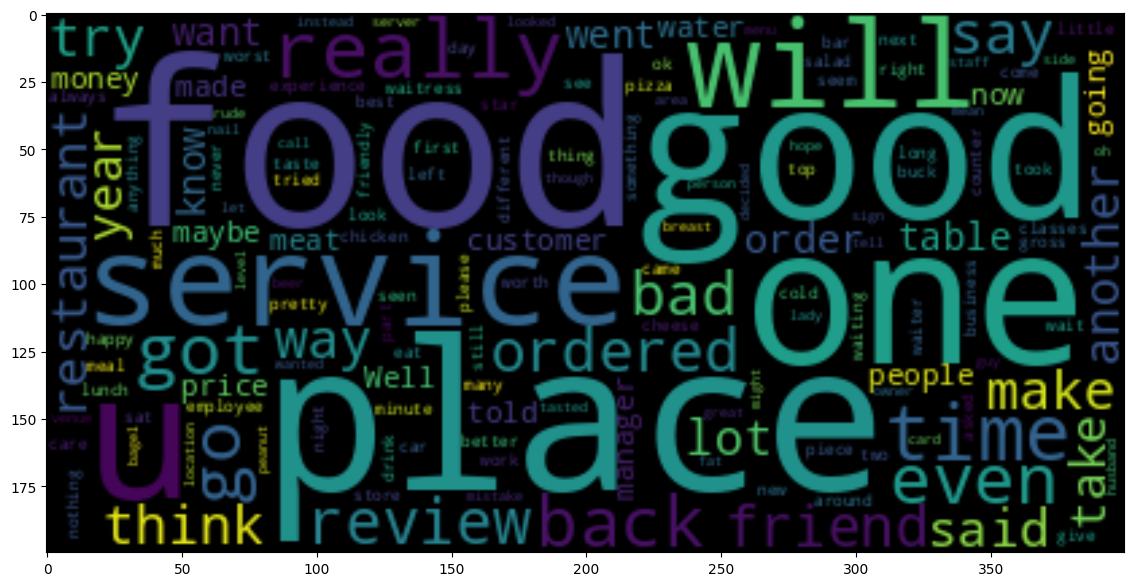

In [6]:
# Word cloud for differently rated reviews
num_stars = 1 # <-change this
this_star_text = ''
for t in yelp[yelp['stars'] == num_stars]['text'].values: # form field cell
    this_star_text += t + ' '

wordcloud = WordCloud()
wordcloud.generate_from_text(this_star_text)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')

# Model


### Exercise: Preparing to Classify

We are trying to do binary classification of sentiment. We will change 4,5 stars to good and 1,2,3 to bad.

In [7]:
def is_good_review(num_stars):
    if (num_stars <= 3): ### YOUR CODE HERE
        return False
    else:
        return True

# Change the stars column to either be 'good' or 'bad'.
yelp['is_good_review'] = yelp['stars'].apply(is_good_review)
yelp.head()

,text,stars,is_good_review
0,My wife took me here on my birthday for breakf...,5,True
1,I have no idea why some people give bad review...,5,True
2,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5,True
3,General Manager Scott Petello is a good egg!!!...,5,True
4,Drop what you're doing and drive here. After I...,5,True


## Text Preprocessing
Preparing the text input using several functions.

First of all, we would like to **tokenize** each review: convert it from a single string into a list of words. Enter some example text into the cell below to see the tokenized version.

We will do this through tokenization, and removal of stop words, common steps in an NLP application.

We will also convert text to vectors using Bag of Words.

**Bag of Words**

In a **bag of words** approach, we count how many times each word was used in each review.

Suppose we want to represent two **reviews**:
- "The food was great. The ambience was also great."
- "Great ambience, but not great food!"

First we define our vocabulary. This is *each unique word* in the review. So our **vocabulary** is:
- [also, ambience, but, food, great, not, the, was].

Next, we count up how many times each word was used! (You can also think of this as adding up one-hot encodings.)



In [8]:
X_text = yelp['text']
y = yelp['is_good_review']

CountVectorizer, a useful tool from Scikit-learn, to:
*   Tokenize our reviews
*   Remove stopwords
*   Prepare our vocabulary


In [9]:
#text cleaning function
def tokenize(text):
    clean_tokens = []
    for token in text_to_nlp(text):
        if (not token.is_stop) & (token.lemma_ != '-PRON-') & (not token.is_punct): # -PRON- is a special all inclusive "lemma" spaCy uses for any pronoun, we want to exclude these
            clean_tokens.append(token.lemma_)
    return clean_tokens


In [10]:
bow_transformer = CountVectorizer(analyzer=tokenize, max_features=800).fit(X_text)

In [11]:
bow_transformer.vocabulary_

{'wife': 781,
 'take': 702,
 'birthday': 103,
 'breakfast': 118,
 'excellent': 264,
 ' ': 2,
 'perfect': 525,
 'sit': 645,
 'outside': 507,
 'waitress': 763,
 'food': 303,
 'arrive': 69,
 'quickly': 569,
 'busy': 129,
 'Saturday': 44,
 'morning': 468,
 'look': 423,
 'like': 411,
 'place': 536,
 'fill': 291,
 'pretty': 555,
 'early': 246,
 'well': 778,
 '\n\n': 1,
 'simply': 643,
 'good': 329,
 'sure': 696,
 'use': 746,
 'ingredient': 383,
 'fresh': 309,
 'order': 504,
 'amazing': 64,
 'menu': 455,
 'white': 779,
 'egg': 250,
 'vegetable': 752,
 'tasty': 705,
 'delicious': 223,
 'come': 174,
 '2': 14,
 'piece': 534,
 'bread': 116,
 'absolutely': 55,
 'meal': 448,
 'toast': 720,
 'wait': 761,
 'idea': 377,
 'people': 523,
 'bad': 84,
 'review': 595,
 'go': 328,
 'probably': 559,
 'case': 140,
 'friend': 312,
 'pm': 544,
 'past': 518,
 'Sunday': 47,
 'think': 714,
 'evening': 261,
 'seat': 618,
 'say': 613,
 'girl': 324,
 'waiter': 762,
 'get': 322,
 'drink': 242,
 'pleasant': 540,
 'serv

In [12]:
len(bow_transformer.vocabulary_)

800

Now lets transform each review into a bag of words.



In [13]:
X = bow_transformer.transform(X_text)

In [14]:
pd.DataFrame(X.toarray())

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0,3,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,18,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
996,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,11,0,0,0,0,0,1,0,0,...,2,0,1,0,1,0,1,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Logistic Regression

Now, back to our sentiment analysis problem! Our data is ready for machine learning.

Our classification problem is a classic two-class classification problem, and so we will use the tried-and-tested **Logistic Regression** machine learning model.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [17]:
logistic_model = LogisticRegression()

logistic_model.fit(X_train,y_train)



LogisticRegression()

In [18]:
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print (accuracy)

0.745


In [21]:
#Enter a review to see your model's classification
example_review = "This restaurant is good" #@param {type:'string'}
prediction = logistic_model.predict(bow_transformer.transform([example_review]))

if prediction:
  print ("This was a GOOD review!")
else:
  print ("This was a BAD review!")



This was a GOOD review!


## Weights

Let's explore your model in more depth.

A dictionary is a data structure that stores information in key:value pairs. You retrieve the value of a given key from a dictionary dict by calling "dict[key]" which returns value. Similary, you can assign a value to a key by calling "dict[key]=value".<br><br> In the case of NLP, we need to store our vocabulary in a dictionary, where the key is the word in string format and the value is the index of that word. So, to find the index of a word in our vocab dictionary we would call "vocab[word]", which would then return the index. Similarly, we can assign a word an index by calling "vocab[word]=index".

Finish writing the following function! It takes in the following:

* `word`: a word from our vocabulary
* `model`: the logistic regression model whose weights we want to query.
* `vocab_dict`: a dictionary containg word:index as the key:value pair.



The function should then return the weight that the logistic regression model has learned for the word in question. (Hint: the model weights (also called coefficients) can be accessed by calling `model.coef_[0][id]`, where `id` is the index of the vocab word in question.)



In [27]:
def get_word_weight(word, model, vocab_dict):
    if word in vocab_dict:

        word_index = vocab_dict[word]

        word_weight = model.coef_[0][word_index]

        return word_weight
    else:
        return "That word is not in our Vocabulary!"

In [26]:
#Input a sentence to see the weights of each word!
sentence = "this is a good place" #@param {type:'string'}
words=tokenize(sentence)
temp_weight_dict={}
for word in words:
  weight=get_word_weight(word,logistic_model,bow_transformer.vocabulary_)
  temp_weight_dict[word]=weight
print(temp_weight_dict,"bias:  "+str(logistic_model.intercept_[0]))


{'good': 0.4163471445002851, 'place': -0.3798752659546322} bias:  0.534082043345935


## Naive Bayes
Multinomial Naive Bayes. Naive Bayes uses Bayes' Theorem of probability to predict the class of new input data. The important assumption that Naive Bayes makes is that all the features are independent.



In [28]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()

In [29]:

nb_model.fit(X_train,y_train)

MultinomialNB()

In [30]:
y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print (accuracy)

0.72


## Logistic Regression with Word Embeddings

In [31]:
text_to_nlp = en_core_web_md.load()

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [32]:
doc = text_to_nlp("I like apples and cherries and peaches and pie")
token = doc[2]
print (token)
print (len(token))

apples
6


In [33]:
print ('Vector for: ', token)
print (token.vector)

Vector for:  apples
[-2.3691   -3.3093   -2.3683    3.9687    0.7657   -2.4125   -2.6989
  2.191    -5.2731    1.4548    4.0483   -1.3258   -2.5053    1.8406
  1.456    -1.8792    2.7844   -3.4126    0.47314  -5.9216   -0.40092
  2.6631   -2.8213   -1.6466   -2.3342   -1.857    -2.5771    1.5269
  0.2391   -1.2999    1.267    -1.5071    0.50731  -2.9986    0.96218
 -1.2704    2.9455    0.61234   2.1324   -0.92046   1.439     0.42566
  1.5614    2.0232   -1.1418    1.4407    0.28988  -0.67582   2.2102
 -1.5918    0.069704  0.6616    1.8213   -2.7202   -2.2525    0.44366
 -2.3768    1.4561    5.1407   -1.5928    2.8267    0.84684   2.8155
  0.6176   -0.47365   0.14659  -2.8028   -3.6587    0.56587  -0.95888
  0.031699  2.5489    0.23451   0.025016  2.1471    1.6193   -6.8539
 -1.9494    4.5936   -0.41406  -1.1074    1.0288    0.55435  -0.59505
  2.0455    1.2122   -0.086148  0.45522  -0.038163 -0.071074  2.2994
  2.6239    3.1491   -4.3686   -1.5754    0.4051    4.4168   -3.227
 -2.0252 

In [35]:
def tokenize_vecs(text):
    clean_tokens = []
    for token in text_to_nlp(text):
        if (not token.is_stop) & (token.lemma_ != '-PRON-') & (not token.is_punct):
          # -PRON- is a special all inclusive "lemma" spaCy uses for any pronoun, we want to exclude these
            clean_tokens.append(token)
    return clean_tokens

## Word Embedding Math



One reason text embeddings are cool is that we can use them to explore connections in meaning between different words, including calculating similarity between words and completing [analogies](http://epsilon-it.utu.fi/wv_demo/).

We'll start by creating a dictionary containing the vectors for all the words in our vocabulary. We'll stick to the vocabulary above of 800 words from the Yelp reviews - if you want to use more words, change that number!

In [42]:
vocab_dict = dict() #initialize dictionary

for word in bow_transformer.vocabulary_:
    vocab_dict[word] = text_to_nlp(word).vector # What is the key? What is the value?

for word, vec in vocab_dict.items(): # Iterating through the dictionary to print each key and value
  print ('Word: {}. Vector length: {}'.format(word, len(vec)))

print()
print ('{} words in our dictionary'.format(len(vocab_dict)))

Word: wife. Vector length: 300
Word: take. Vector length: 300
Word: birthday. Vector length: 300
Word: breakfast. Vector length: 300
Word: excellent. Vector length: 300
Word:  . Vector length: 300
Word: perfect. Vector length: 300
Word: sit. Vector length: 300
Word: outside. Vector length: 300
Word: waitress. Vector length: 300
Word: food. Vector length: 300
Word: arrive. Vector length: 300
Word: quickly. Vector length: 300
Word: busy. Vector length: 300
Word: Saturday. Vector length: 300
Word: morning. Vector length: 300
Word: look. Vector length: 300
Word: like. Vector length: 300
Word: place. Vector length: 300
Word: fill. Vector length: 300
Word: pretty. Vector length: 300
Word: early. Vector length: 300
Word: well. Vector length: 300
Word: 

. Vector length: 300
Word: simply. Vector length: 300
Word: good. Vector length: 300
Word: sure. Vector length: 300
Word: use. Vector length: 300
Word: ingredient. Vector length: 300
Word: fresh. Vector length: 300
Word: order. Vector length: 

Next, let's calculate the similarity between two words, using their Word2Vec representations.

A common way to calculate the similarity between two vectors is called *cosine similarity*. It depends on the angle between those two vectors when plotted in space. As an example, imagine we had two three-dimensional vectors:

In [43]:
v0 = [2,3,1]
v1 = [2,4,1]

In [44]:
#  create an interactive 3D plot
#Code from https://stackoverflow.com/questions/47319238/python-plot-3d-vectors
import numpy as np
import plotly.graph_objs as go

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""

    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()


vector_plot([v0,v1])

For our Word2Vec vectors, we can imagine doing the same thing in 300-dimensional space. Of course, it's much harder to plot that!

Then we find the cosine of the angle between the two vectors to get the similarity.



Please implement cosine similarity below, and test it out using our 3-dimensional vectors from above. Do the results make sense?


In [46]:
def vector_cosine_similarity(vec1,vec2):
  dot_product = np.dot(vec1, vec2)

    # Calculate the magnitudes (norms) of vec1 and vec2
  norm_vec1 = np.linalg.norm(vec1)
  norm_vec2 = np.linalg.norm(vec2)

    # Calculate cosine similarity
  cosine_similarity = dot_product / (norm_vec1 * norm_vec2)

  return cosine_similarity

print(vector_cosine_similarity(v0,v1))

0.9914601339836675


Cosine similarity of 2 words

In [48]:
def word_similarity(word1, word2):
  #Should return a similarity between -1 and 1

  try:
    vec1 = vocab_dict[word1]
    vec2 = vocab_dict[word2]

    return vector_cosine_similarity(vec1, vec2)


  except KeyError:
    print ('Word not in dictionary')

print(word_similarity('burger','steak'))

0.7387349
